# How can frog grow its tail back?


In [5]:
#!pip install anndata
#!pip install 'scanpy[leiden]'

In this starter we provide some built-in functions for PCA and subsequent Leiden Clustering. We do not reqruire you write down PCA in this task, but for more details as to how you should use it, `scanpy` uses the `sklearn` PCA routine - for `R` users, there might be some usage discrepancies. Scaling/centering data is not automatically done and can be a careful choice here. For additional information on single cell specific use, you can consult this [tutorial](https://training.galaxyproject.org/training-material/topics/single-cell/tutorials/scrna-scanpy-pbmc3k/tutorial.html#dimensionality-reduction).


For the project, ask yourself some questions: why do we do PCA? how does this affect our data? how does the scaling affect? should we scale? what is the impact of the processing steps? does the interpretation carry over from classical ML use? How does the two formulations of PCA help you understand what is going on here?

## Processing the data

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install scanpy


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=c0c07dda342298982c7f2a82440ab4187b2714e1b19781775ab9bfe2170dff9b
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [8]:
import scanpy as sc
extract_dir = "/content/drive/MyDrive/TA/Frogtail_files/" # use your own directory
adata = sc.read_h5ad(extract_dir+'cleaned_processed_frogtail (2).h5ad') # file path

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
adata.obs.head()

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3


In [10]:
adata.obs.shape

(13199, 13)

In [11]:
adata.obs.isnull().sum()

,0
barcode_cells,0
cell,0
sample,0
DevelopmentalStage,0
DaysPostAmputation,0
cluster,0
X,0
Y,0
CellCyclePhase,0
Sample,0


We need to select a timepoint. Let's plot them out first.

<Axes: xlabel='DaysPostAmputation', ylabel='Count'>

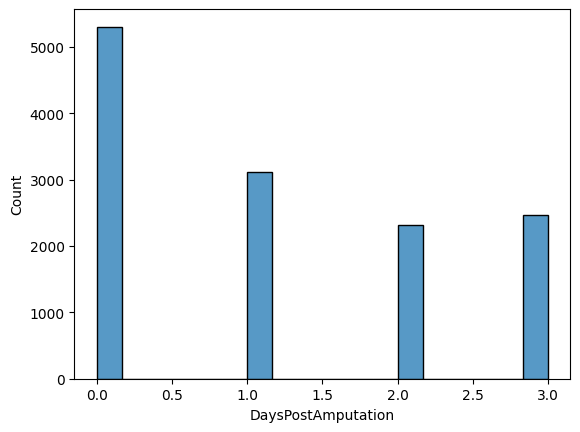

In [12]:
import seaborn as sns
sns.histplot(adata.obs['DaysPostAmputation'])

Selecting timepoint 0 (Day of amputation).

In [13]:
adata = adata[adata.obs['DaysPostAmputation'] == 0] # Subset on the time point 0
adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer

<ipython-input-13-88f00e64bca0>:2: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts'] = adata.X.copy() # Copy the raw counts in a different layer


In [14]:
# Log-normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [15]:
# Find highly variable genes (HVG)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)  # adjust the number of genes if needed
hvg_adata = adata[:, adata.var['highly_variable']].copy()

## PCA whitening for Leiden clustering



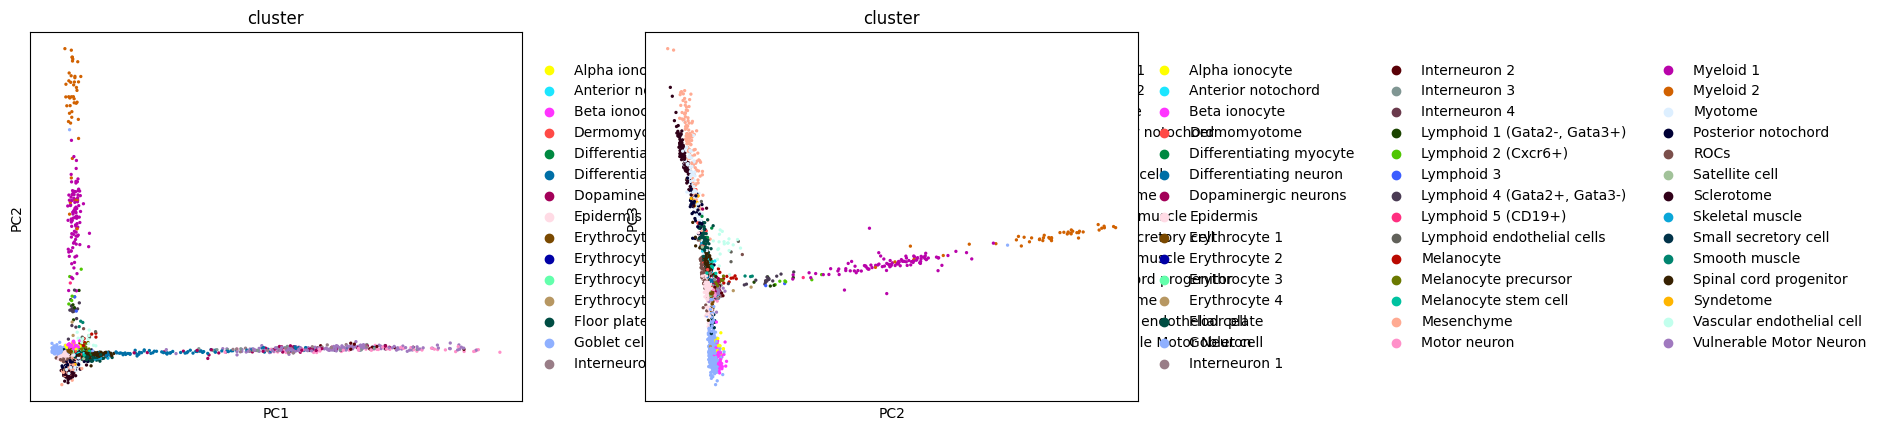

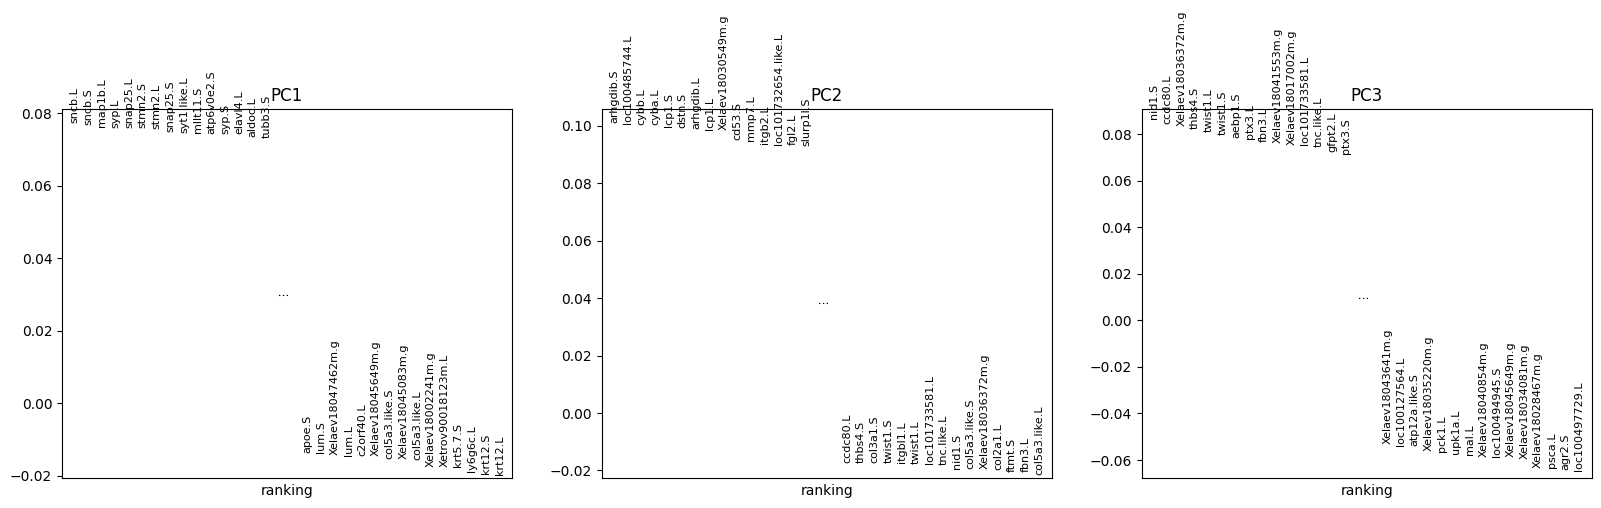

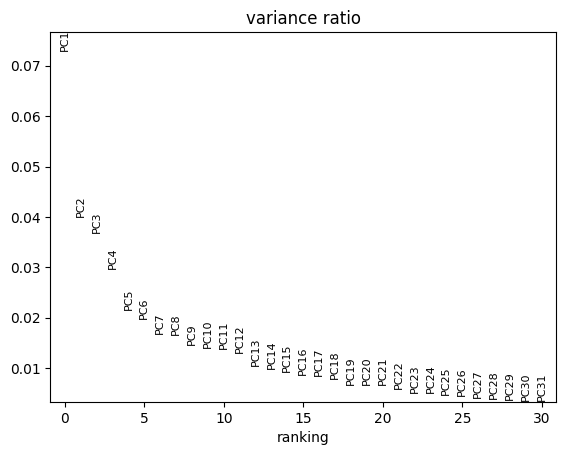

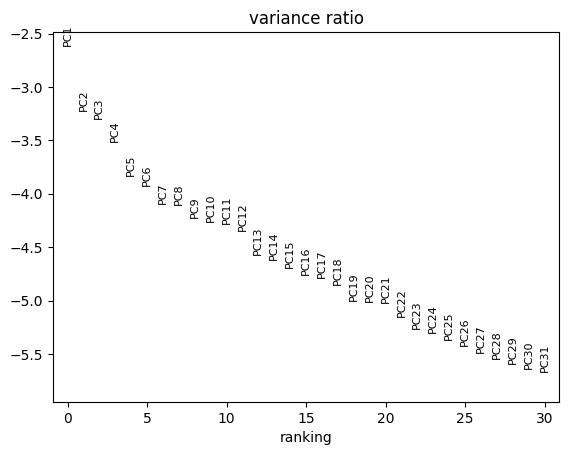

In [16]:
sc.pp.scale(hvg_adata) # Scale data

# Do PCA on the highly variable genes data - you might need to lognormalize to select HVG
sc.tl.pca(hvg_adata)
sc.pp.pca(hvg_adata)

sc.pl.pca_overview(hvg_adata, color='cluster', components= ['1,2', '2,3']) # Plot all diagnostics including PC1 against PC2 and PC2 against PC3
# Correct the variance ratio plot to use hvg_adata, which contains the PCA results
sc.pl.pca_variance_ratio(hvg_adata, log=True)


## Apply Leiden clustering

In [17]:
!pip install python-igraph
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.0 MB/s eta 0:00:00


In [18]:
# Whitening step - create neighbors graph based on PCA
sc.pp.neighbors(hvg_adata, n_pcs=7) # Create neighbors graph - n_pcs takes the number of principal components from PCA you keep for this step
sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter


<ipython-input-18-0291f543527e>:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(hvg_adata, resolution=0.5)  # Apply Leiden clustering, you can adjust the resolution parameter


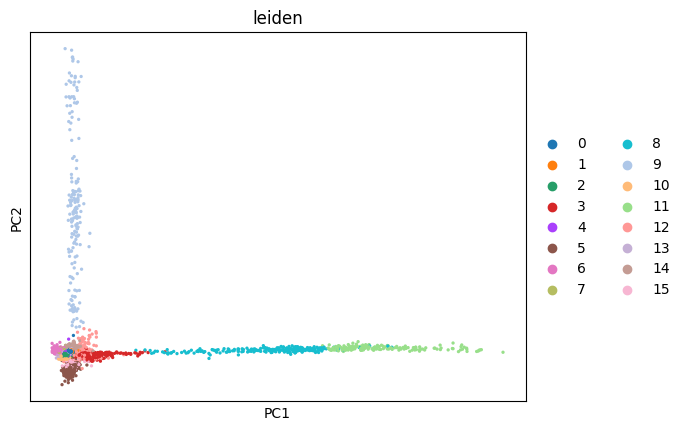

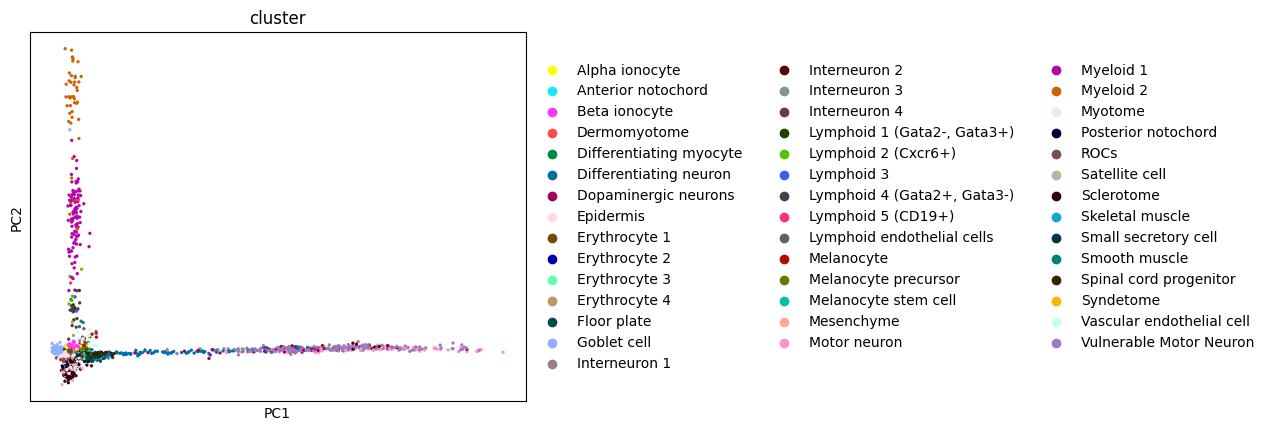

In [19]:
sc.pl.pca(hvg_adata, color=['leiden']) # Plotting PC1/PC2 with colors from Leiden labels
sc.pl.pca(hvg_adata, color=['cluster']) # Plotting PC1/PC2 with colors from original paper cluster

# **Clustering Analysis**

In [20]:
!pip install louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00


In [21]:
import scanpy as sc
sc.tl.pca(hvg_adata, n_comps=7)
sc.tl.louvain(hvg_adata, resolution=0.5)

sc.tl.leiden(hvg_adata, resolution=0.5)
sc.pp.neighbors(hvg_adata, n_pcs=7)

from sklearn.cluster import KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
hvg_adata.obs['kNN'] = kmeans.fit_predict(hvg_adata.obsm['X_pca'])

from sklearn.metrics import silhouette_score, adjusted_rand_score

leiden_labels = hvg_adata.obs['leiden'].astype(int)
louvain_labels = hvg_adata.obs['louvain'].astype(int)
knn_labels = hvg_adata.obs['kNN'].astype(int)

silhouette_leiden = silhouette_score(hvg_adata.obsm['X_pca'], leiden_labels)
silhouette_louvain = silhouette_score(hvg_adata.obsm['X_pca'], louvain_labels)
silhouette_knn = silhouette_score(hvg_adata.obsm['X_pca'], knn_labels)

ari_louvain_leiden = adjusted_rand_score(leiden_labels, louvain_labels)

print("Silhouette Score (Leiden):", silhouette_leiden)
print("Silhouette Score (Louvain):", silhouette_louvain)
print("Silhouette Score (kNN):", silhouette_knn)
print("Adjusted Rand Index (Louvain vs. Leiden):", ari_louvain_leiden)


Silhouette Score (Leiden): 0.339862
Silhouette Score (Louvain): 0.35164717
Silhouette Score (kNN): 0.46495453
Adjusted Rand Index (Louvain vs. Leiden): 0.8179491182142075


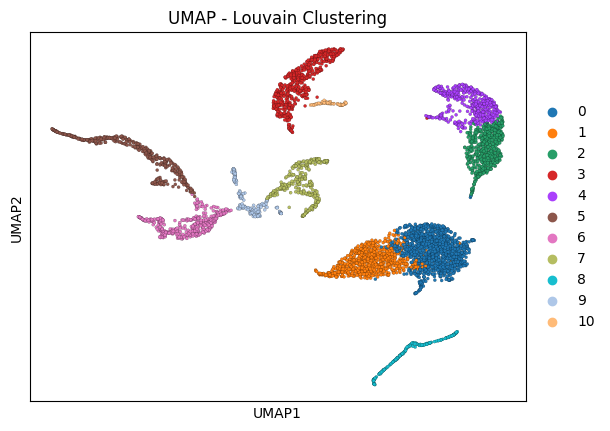

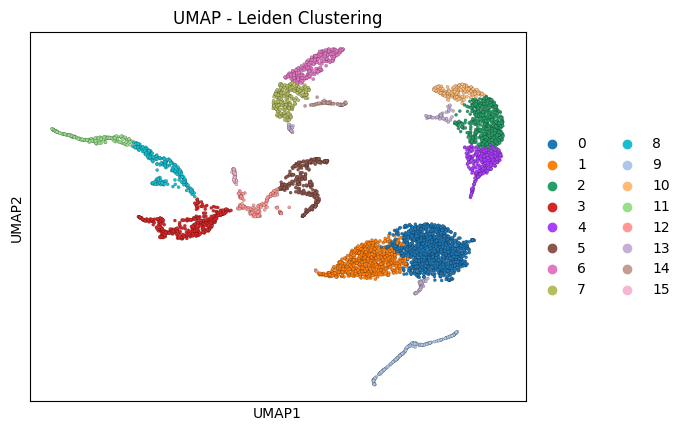

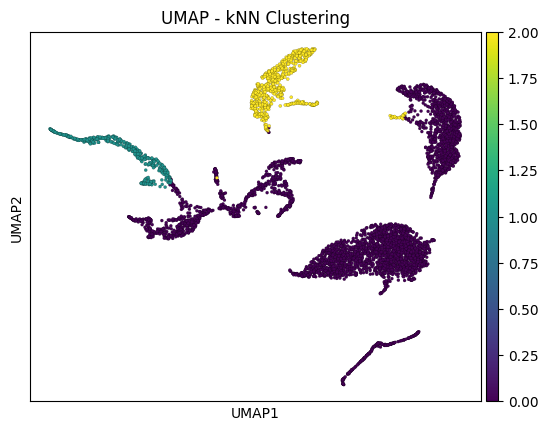

In [22]:
import scanpy as sc

sc.pp.neighbors(hvg_adata, n_pcs=7, n_neighbors=15)
sc.tl.umap(hvg_adata, min_dist=0.4)

sc.pl.umap(hvg_adata, color='louvain', title='UMAP - Louvain Clustering', size=20, edgecolor='k', linewidth=0.1)

sc.pl.umap(hvg_adata, color='leiden', title='UMAP - Leiden Clustering', size=20, edgecolor='k', linewidth=0.1)

sc.pl.umap(hvg_adata, color='kNN', title='UMAP - kNN Clustering', size=20, edgecolor='k', linewidth=0.1)


# **Use at least two marker selection methods**

In [23]:
import scanpy as sc
import pandas as pd

min_cells = 5
sc.pp.filter_genes(hvg_adata, min_cells=min_cells)

hvg_adata.X += 1
sc.tl.rank_genes_groups(hvg_adata, groupby='louvain', method='wilcoxon', n_genes=200)

diff_exp_results = sc.get.rank_genes_groups_df(hvg_adata, group='0')
diff_exp_results['method'] = 'Differential Expression'

print("Top markers from Differential Expression Analysis:")
print(diff_exp_results.head())

hvg_genes = hvg_adata.var['highly_variable']
variance_markers = hvg_adata.var_names[hvg_genes]

variance_results = pd.DataFrame({'names': variance_markers, 'scores': [1]*len(variance_markers)})  # Scores can be placeholder
variance_results['method'] = 'Variance-Based Feature Selection'

combined_results = pd.concat([diff_exp_results[['names', 'scores', 'method']], variance_results], axis=0)
print("Combined marker results from both methods:")
combined_results.head()


Top markers from Differential Expression Analysis:
               names     scores  logfoldchanges          pvals      pvals_adj  \
0  Xelaev18002241m.g  50.789581        3.664513   0.000000e+00   0.000000e+00   
1              ca2.L  50.140278        3.526180   0.000000e+00   0.000000e+00   
2  Xelaev18045083m.g  35.609463        2.887840  1.000010e-277  1.887020e-275   
3  Xelaev18047462m.g  28.458645        1.974324  3.809194e-178  5.529192e-176   
4  Xelaev18047453m.g  20.910423        0.747203   4.303941e-97   4.274493e-95   

                    method  
0  Differential Expression  
1  Differential Expression  
2  Differential Expression  
3  Differential Expression  
4  Differential Expression  
Combined marker results from both methods:


,names,scores,method
0,Xelaev18002241m.g,50.789581,Differential Expression
1,ca2.L,50.140278,Differential Expression
2,Xelaev18045083m.g,35.609463,Differential Expression
3,Xelaev18047462m.g,28.458645,Differential Expression
4,Xelaev18047453m.g,20.910423,Differential Expression


**Use logistic regression or other methods to identify marker genes. Annotate the clusters using the markers identified**

In [24]:
import scanpy as sc
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

if hvg_adata.raw is None:
    hvg_adata.raw = hvg_adata

marker_genes = combined_results['names'].tolist()

X = hvg_adata.raw[:, marker_genes].X
y = hvg_adata.obs['louvain']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_scaled, y)

importance = log_reg.coef_[0]
marker_importance = pd.DataFrame({'gene': marker_genes, 'importance': importance})
marker_importance = marker_importance.sort_values(by='importance', ascending=False)

print("Top markers identified using logistic regression:")
print(marker_importance.head())

def annotate_clusters(adata, marker_genes):
    gene_data = {}

    for gene in marker_genes:
        gene_data[gene] = adata.raw[:, gene].X.flatten()

    gene_df = pd.DataFrame(gene_data, index=adata.obs.index)

    adata.obs = pd.concat([adata.obs, gene_df], axis=1)
    adata.obs['Cluster_Annotation'] = adata.obs.apply(lambda x: 'Marker1' if x['gene1'] > threshold else 'Other', axis=1)


Top markers identified using logistic regression:
                gene  importance
1504         itln1.L    0.426715
1241          bmp2.S    0.414522
1832       col27a1.S    0.391201
294       atp6v1b1.L    0.363432
1506  loc100494753.L    0.352887


### **Compare the identified markers across different methods**

<ipython-input-25-ad19f578a53a>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_markers = combined_results.groupby('method').apply(lambda x: x.nlargest(top_n, 'scores')).reset_index(drop=True)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. 

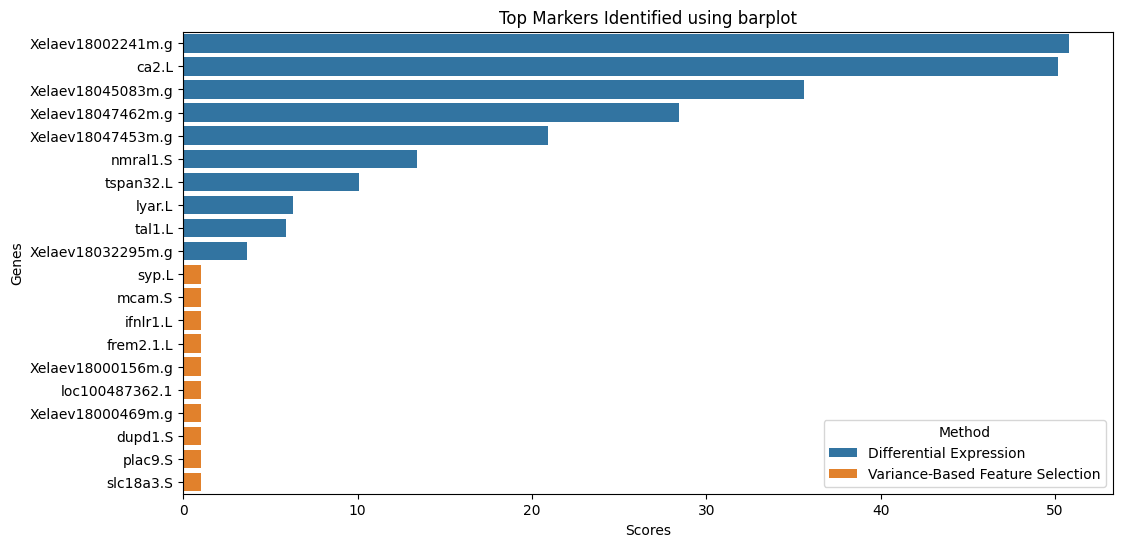

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
top_n = 10
top_markers = combined_results.groupby('method').apply(lambda x: x.nlargest(top_n, 'scores')).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='scores', y='names', hue='method', data=top_markers)
plt.title('Top Markers Identified using barplot')
plt.xlabel('Scores')
plt.ylabel('Genes')
plt.legend(title='Method')
plt.show()


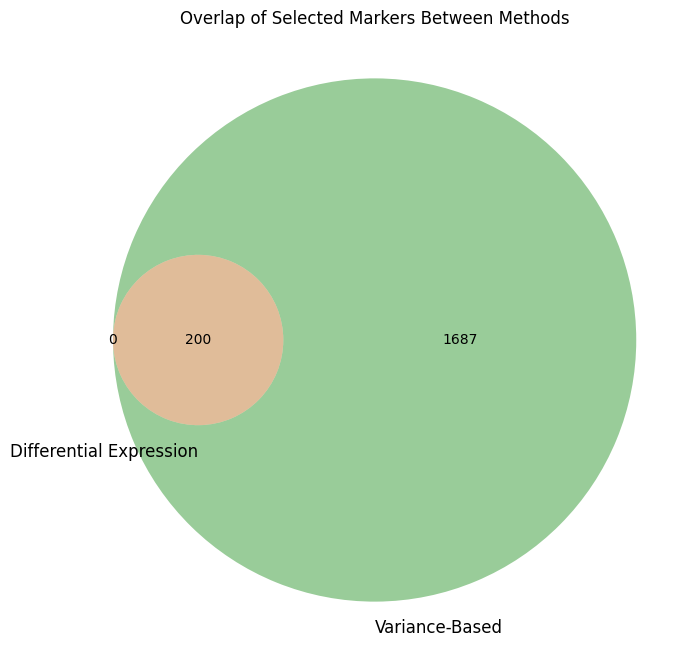

In [26]:
from matplotlib_venn import venn2

diff_exp_genes = set(diff_exp_results['names'])
variance_genes = set(variance_results['names'])

plt.figure(figsize=(8, 8))
venn2([diff_exp_genes, variance_genes], ('Differential Expression', 'Variance-Based'))
plt.title('Overlap of Selected Markers Between Methods')
plt.show()


### **Compare the identified markers across different methods**

In [27]:
num_diff_exp_markers = diff_exp_results['names'].nunique()
num_variance_markers = variance_results['names'].nunique()

overlap = diff_exp_genes.intersection(variance_genes)
num_overlap = len(overlap)

print(f"Number of unique markers from Differential Expression Analysis: {num_diff_exp_markers}")
print(f"Number of unique markers from Variance-Based Feature Selection: {num_variance_markers}")
print(f"Number of markers shared between methods: {num_overlap}")


Number of unique markers from Differential Expression Analysis: 200
Number of unique markers from Variance-Based Feature Selection: 1887
Number of markers shared between methods: 200


### **Compare your gene set with the genes listed in Supplementary Table 3**

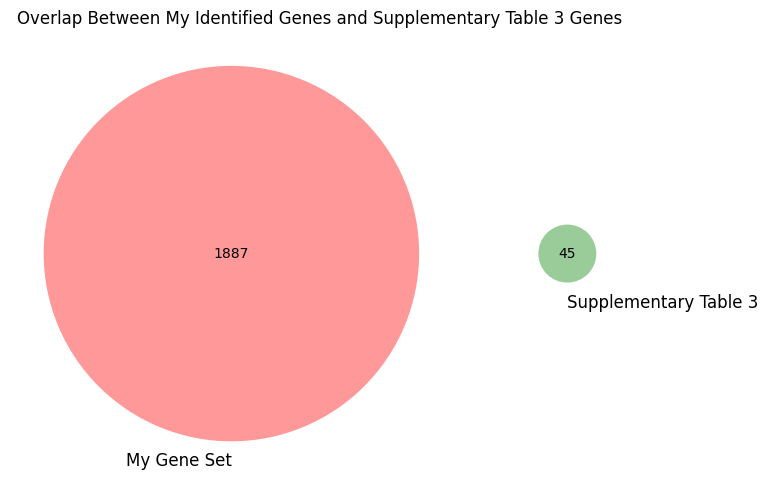

Common genes between my set and Supplementary Table 3: set()
Number of genes unique to my set: 1887
Number of genes unique to Supplementary Table 3: 45
Number of overlapping genes: 0


In [28]:
table_3_genes = ['wnt5a', 'loc100488523', 'loc100492954', 'egfl6', 'lpar3', 'cpa6', 'sp9', 'fgf9', 'fbn2',
                 'tinagl1', 'fgf7', 'vwde', 'lef1', 'lamb2', 'fgfr4', 'fgf7', 'rspo2', 'cpa6', 'loc100498358',
                 'krt', 'loc100486832', 'jag1', 'Xelaev18043128m', 'dlx2', 'tp73', 'gdf6', 'Xelaev18046800m',
                 'nid2', 'igfbp2', 'ism2', 'dlx2', 'loc100493805', 'frem2', 'Xelaev18044182m', 'bmp5', 'tspear',
                 'sema3f', 'robo4', 'jchain', 'rspo2', 'adamts18', 'pltp', 'Xelaev18034799m', 'lamb1', 'unc5b',
                 'mmp28', 'fgf10', 'pzp', 'galnt15']
my_genes = set(combined_results['names'])

table_3_genes_set = set(table_3_genes)

from matplotlib_venn import venn2
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
venn2([my_genes, table_3_genes_set], ('My Gene Set', 'Supplementary Table 3'))
plt.title('Overlap Between My Identified Genes and Supplementary Table 3 Genes')
plt.show()

common_genes = my_genes.intersection(table_3_genes_set)
print(f"Common genes between my set and Supplementary Table 3: {common_genes}")

unique_my_genes = my_genes - table_3_genes_set
unique_table_3_genes = table_3_genes_set - my_genes

print(f"Number of genes unique to my set: {len(unique_my_genes)}")
print(f"Number of genes unique to Supplementary Table 3: {len(unique_table_3_genes)}")
print(f"Number of overlapping genes: {len(common_genes)}")


### **Optionally, perform Gene Ontology (GO) analysis to explore the biological roles of these genes in other contexts**

In [29]:
!pip install gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 9.4 MB/s eta 0:00:00


In [30]:
import gseapy as gp

gene_set = list(my_genes)

go_enrichment = gp.enrichr(gene_list=gene_set,
                            gene_sets='GO_Biological_Process_2021',
                            organism='Human')

go_enrichment.results.head()


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,positive regulation of sodium ion transport (G...,1/13,0.724380,0.992995,0,0,0.799797,0.257885,PRSS8
1,GO_Biological_Process_2021,regulation of sodium ion transport (GO:0002028),1/36,0.971870,0.992995,0,0,0.273868,0.007814,PRSS8
2,GO_Biological_Process_2021,positive regulation of ion transport (GO:0043270),1/50,0.992995,0.992995,0,0,0.195468,0.001374,PRSS8
